МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

<Ответ> Объекты - пары (запрос, документ). Целевые метки - y(запрос, документ) из множества рейтингов. Чем больше y, тем релевантней документ по данному запросу. Сравнимы только те пары, у которых одинаковый запрос.

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

<Ответ> NDCG учитывает степень релеванстности документа, в отличие от MAP

**3.** Почему говорят, что все основные метрики качества дискретны?

<Ответ> При фиксированных ответах основные метрики принимают конечное число значений и зависят только от порядка документов.

**4.** В чем преимущество факторизации в модели RankNet?

<Ответ> Можно выполнять градиентный спуск по парам запрос-документ. Ушли от квадратичной скорости сходимости к почти линейной.

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

<Ответ> Задача минимизации функции потерь сводится к эквивалентной задаче с гладкой функцией потерь (которую мы не знаем, но она существует).

**6.** Какое преобразование данных используется в модели RankSVM?

<Ответ> Вместо пары (запрос, документ) мы берем пары пар запрос документ и выдаем индикатор того, что первая релевантней второй.

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

<Ответ> Оценка сверху - $(1 - \min_{ij} p_{ij})^n, $ если переходит на страницу, отличную от текущей, то min будет больше, следовательно $(1 - min)^n$ меньше, следовательно оценка будет ниже.

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

<Ответ> С точки зрения теории - нет смысла, так как предел один и тот же. С точки зрения практики - моделирует поводение пользователя.

# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

**3.** Пользователь браузера в дополнение к кликам по ссылкам может перейти по кнопке *Назад* и вернуться на предыдущую страницу? Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

<Решения>

## Часть 1

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('text.latex', unicode=True)
plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
plt.rc('font', family='serif', size='16')

/home/anya/.local/lib/python3.4/site-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [2]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1

    # print(N)
    prob_matrix = np.matrix(np.ones(shape=(N, N)) * damping_factor / N)
    vertices_outdegree = np.zeros(N)  
    for edge in links:
        vertices_outdegree[edge[0]] = vertices_outdegree[edge[0]] + 1.
    
    for edge in links:
        prob_matrix[edge[0], edge[1]] = prob_matrix[edge[0], edge[1]]\
        + (1 - damping_factor) / vertices_outdegree[edge[0]]
    
    for index, outdeg in enumerate(vertices_outdegree):
        if outdeg == 0:
            prob_matrix[index] = np.matrix(np.ones(N)/N)
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False, N=None):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.

        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости

        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, damping_factor=damping_factor, N=N)
    distribution = np.matrix(start_distribution)
    next_distribution = np.array(distribution * prob_matrix).ravel()
    counter = 0
    trace = list(start_distribution)
    #print current_distribution, next_distribution
    
    while np.abs(next_distribution - distribution).max() > tolerance:
        counter = counter + 1
        distribution = next_distribution
        next_distribution = np.array(distribution * prob_matrix).ravel()
        trace.append(distribution)
        
    #print counter
    distribution = next_distribution
    trace.append(distribution)
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
def random_graph(n, p):
    return [[i,j] for i in range(n) for j in range(n) if bernoulli(p).rvs()]

Теперь сгенерируем случайный граф и нарисуем его.

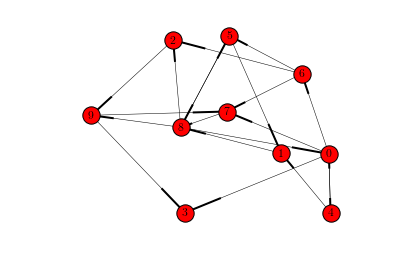

In [4]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

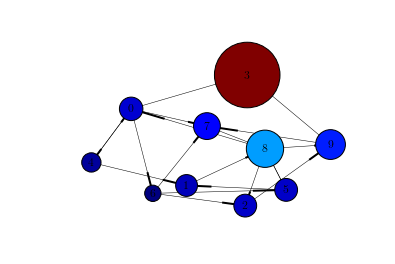

In [5]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

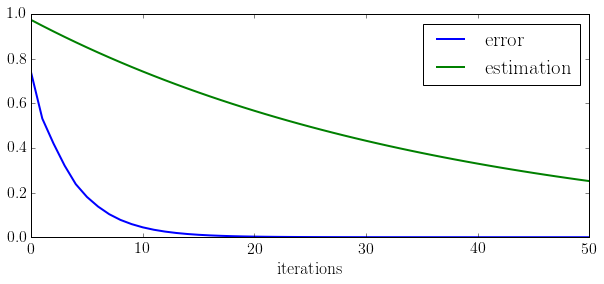

In [6]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=1)

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))

estim = 1 - pr_distribution.min()
estimations = list([estim])
for i in range(1,len(errors)):
    estimations.append(estimations[-1] * estim)
    
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimations, 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

Пользуюсь оценкой:
$$ |\pi_{j} - p_{ij}| <= |M_{j}^{(n)} - m_{j}^{(n)}| <= (1- \epsilon) ^ {n}, $$
где $\epsilon = \min_{i,j} p_{ij}$

<Выводы>

На практике (по результатам 10 запусков ячеек выше) page rank сзодится много быстрее, чем оценка сверху. С среднем 20 итераций хватает для схождения при данных n и p.

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

<Исследования и выводы>

In [7]:
%pylab inline
def test_page_rank(N, p, random_jump_proba=0.15):
    edges = random_graph(N, p)

    G = networkx.DiGraph()
    G.add_edges_from(edges)
    fig, axs = subplots(1,3, figsize=(15,3))
    title("N = {}, p={}, random jump probability = {}".format(N, p, random_jump_proba))
    axs[0].axis('off')
    networkx.draw_networkx(G, width=0.5, ax=axs[0])
    
    start_distribution = np.ones((1, N)) / N
    pr_distribution = page_rank(edges, start_distribution, N=N)

    size_const = 10 ** 4
    axs[1].axis('off')
    networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                           node_color=pr_distribution, ax=axs[1])
    
    pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True, damping_factor=random_jump_proba)
    errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=1)
    x = np.arange(len(errors))

    estim = 1 - pr_distribution.min()
    estimations = list([estim])
    for i in range(1,len(errors)):
        estimations.append(estimations[-1] * estim)

    axs[2].plot(x, errors, lw=2, label='error')
    axs[2].plot(x, estimations, 
             lw=2, label='estimation')
    axs[2].legend()
    axs[2].set_xlabel('iterations')
    show()
    return len(x)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


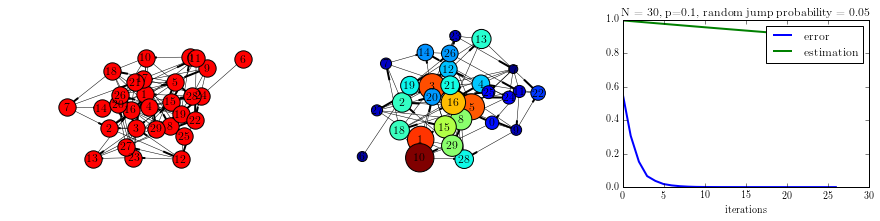

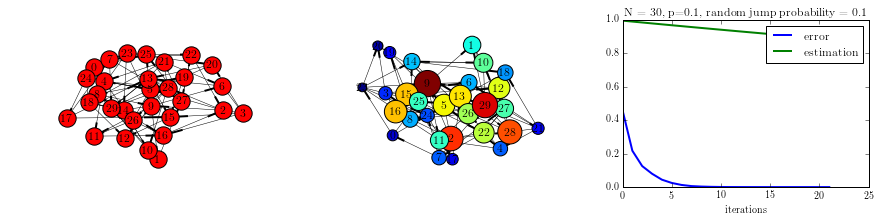

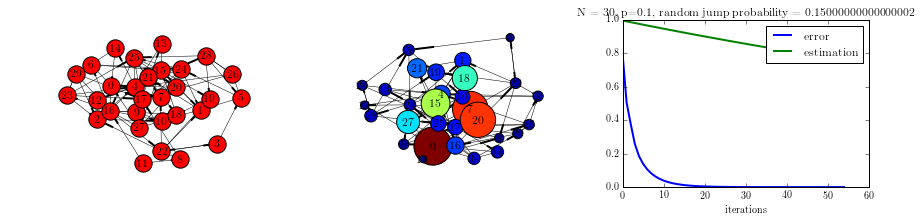

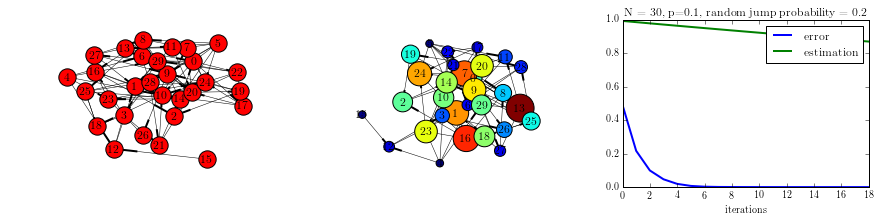

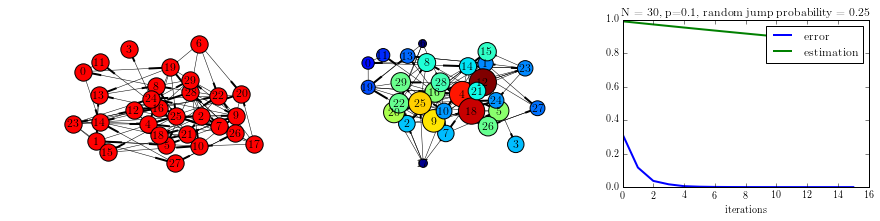

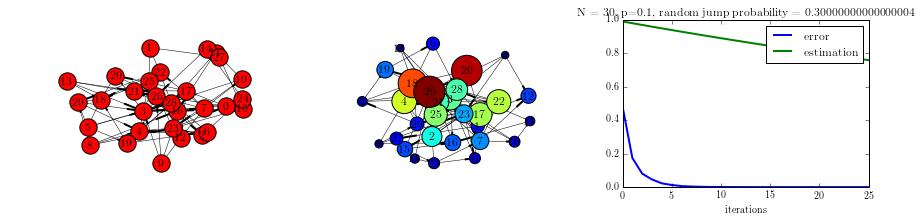

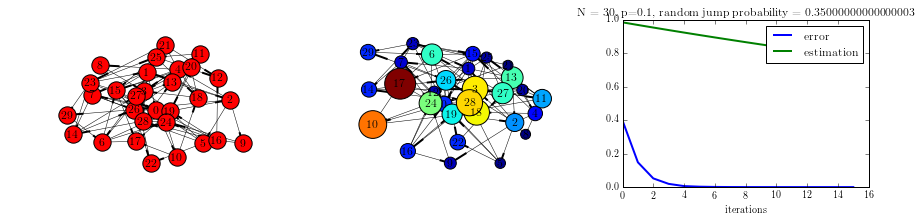

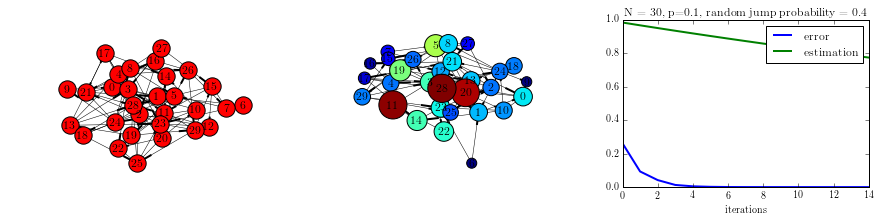

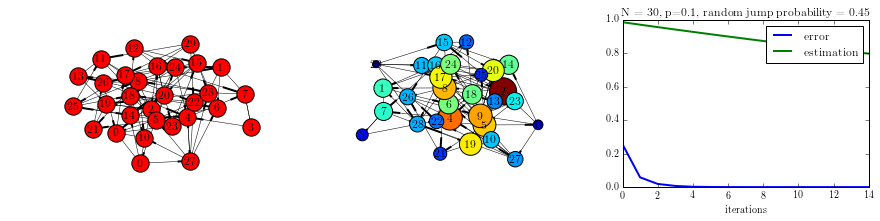

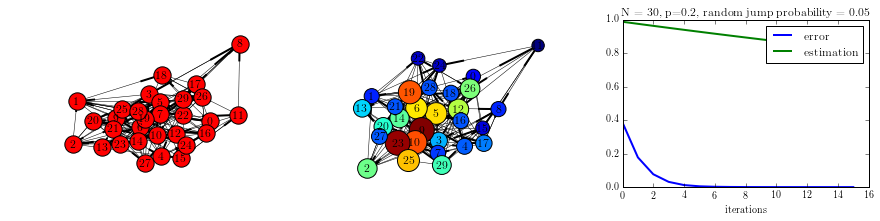

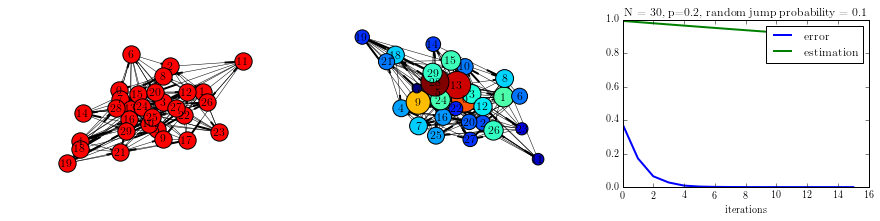

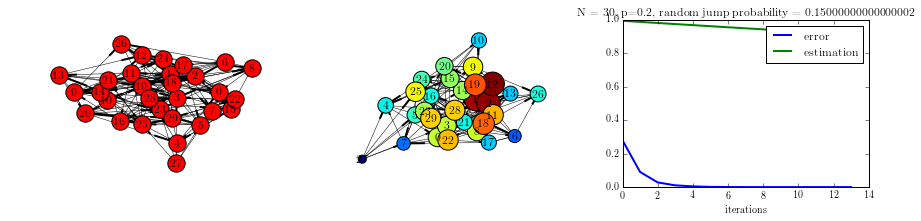

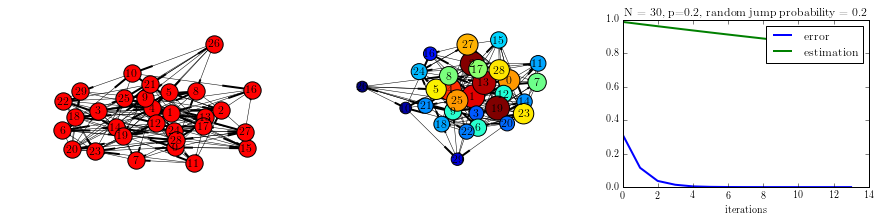

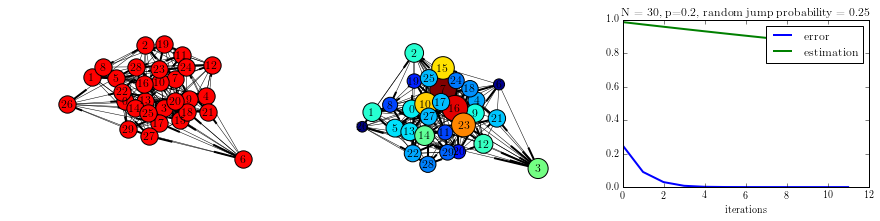

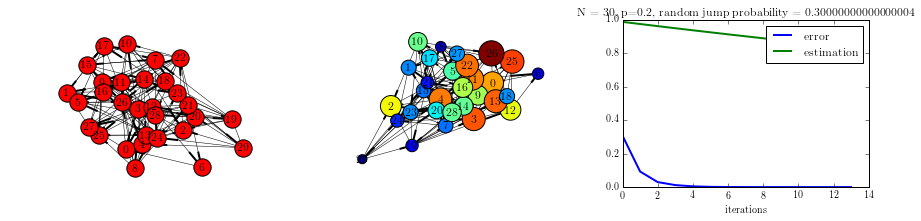

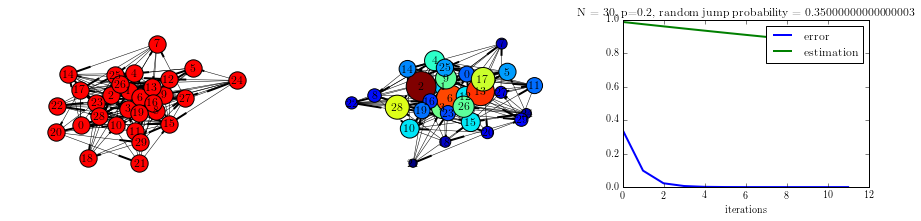

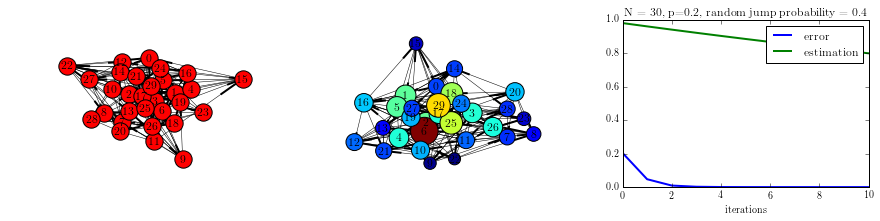

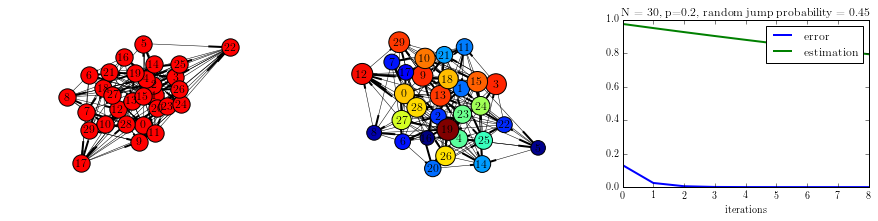

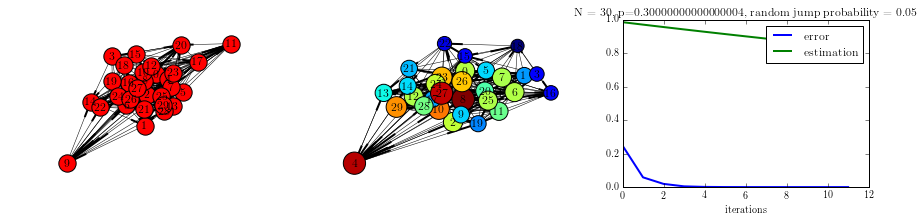

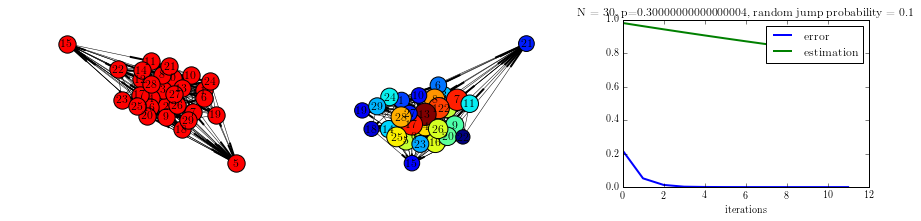

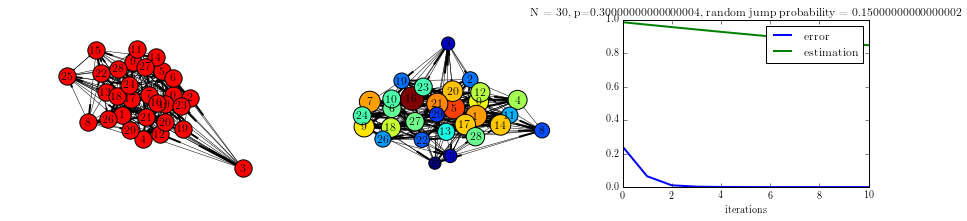

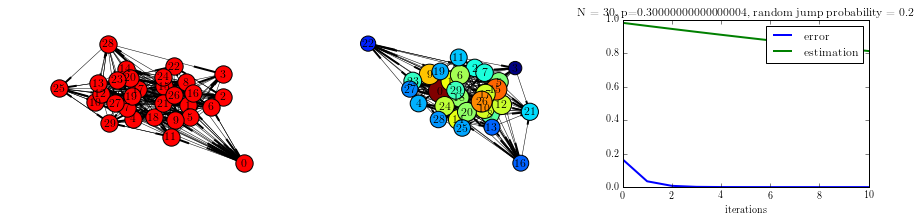

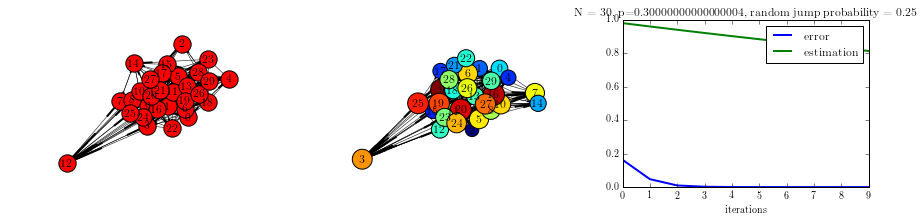

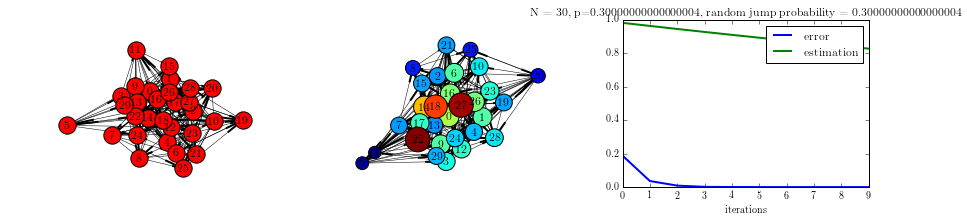

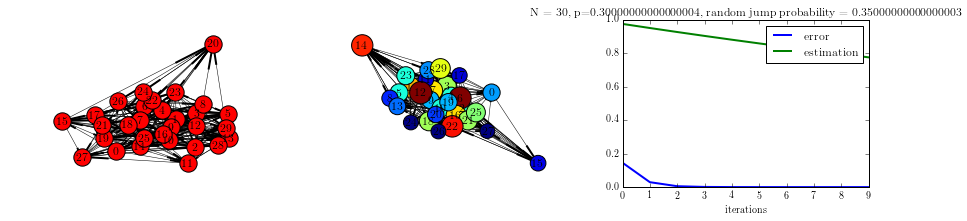

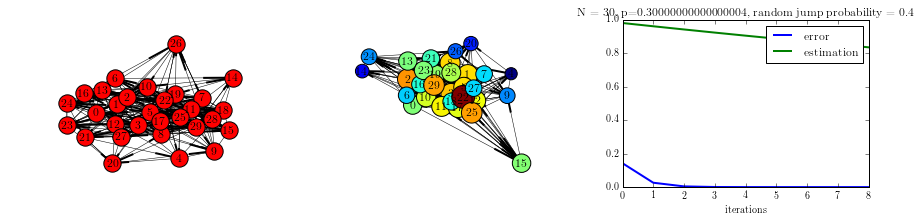

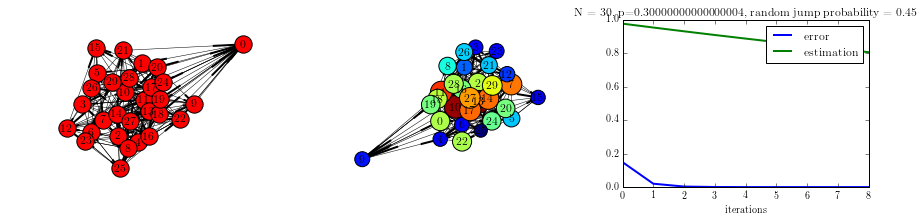

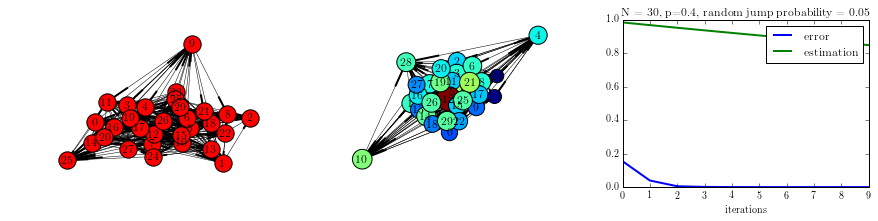

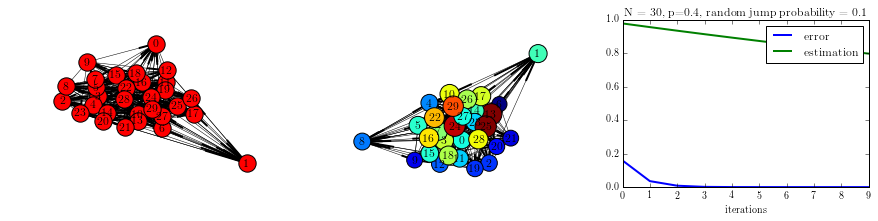

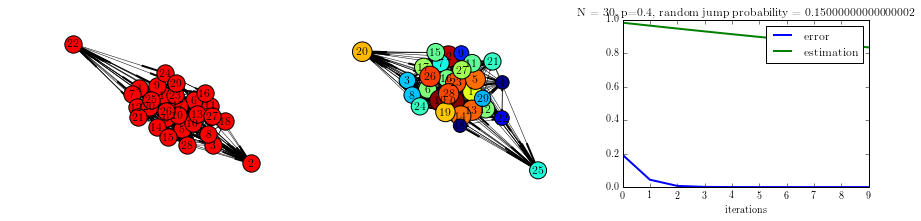

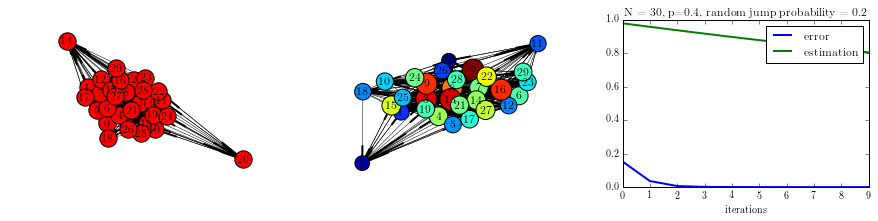

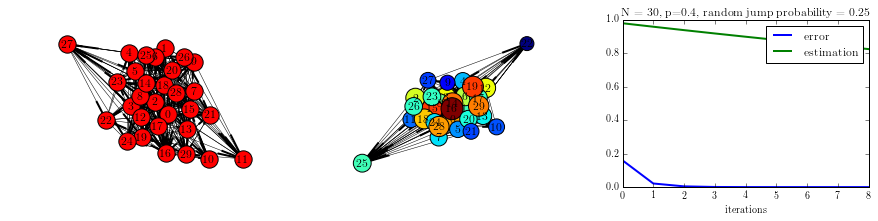

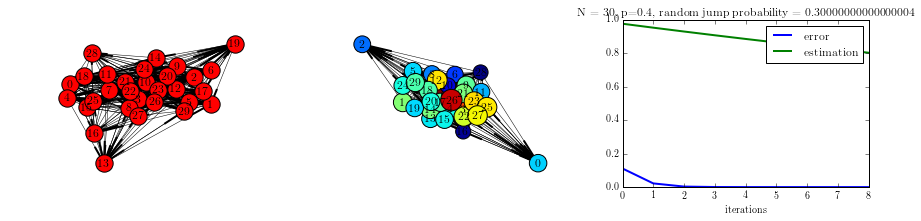

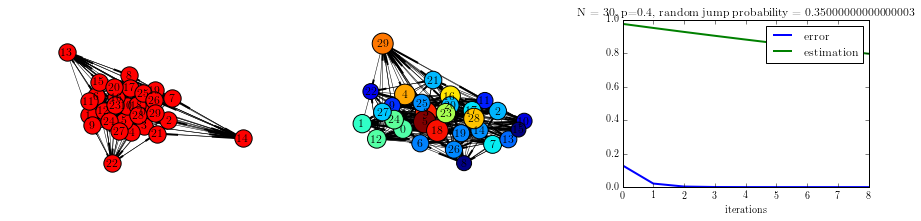

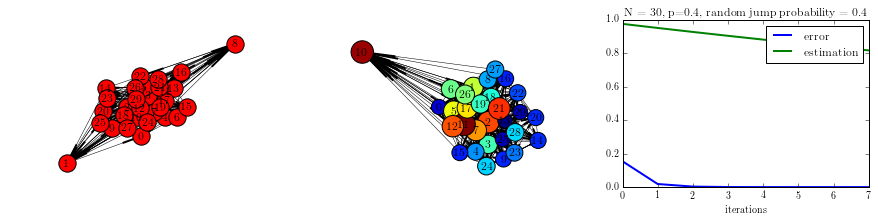

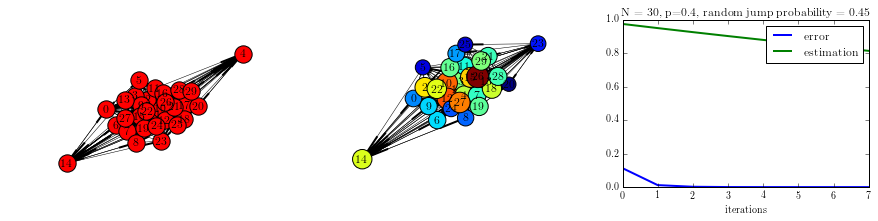

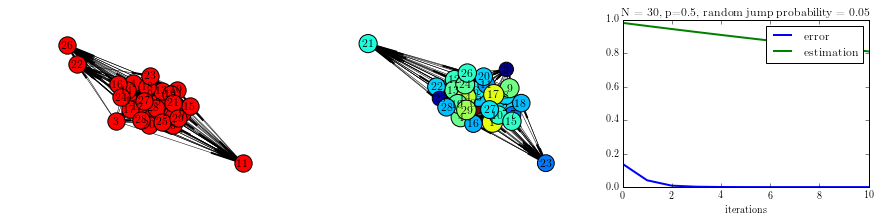

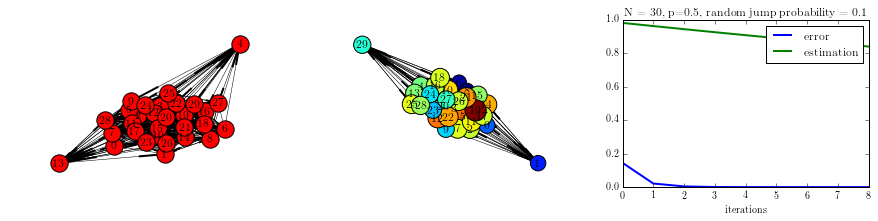

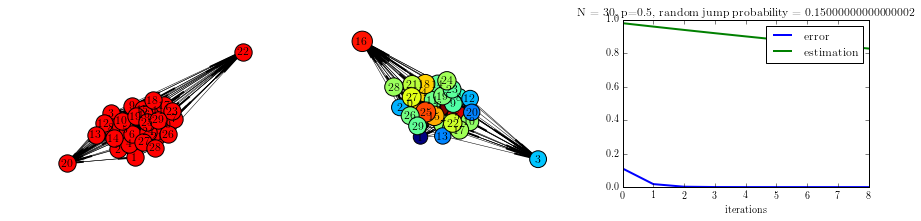

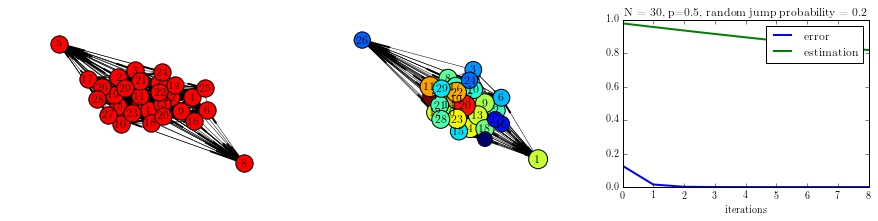

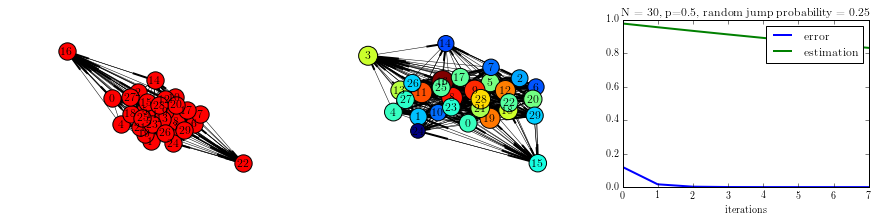

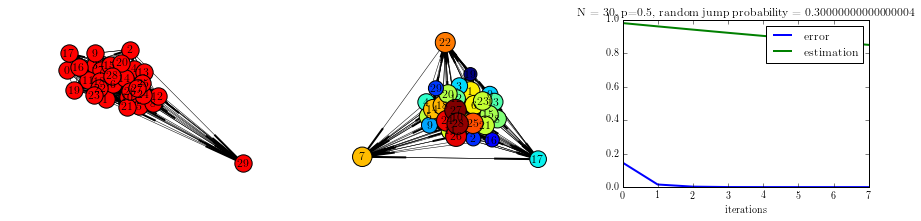

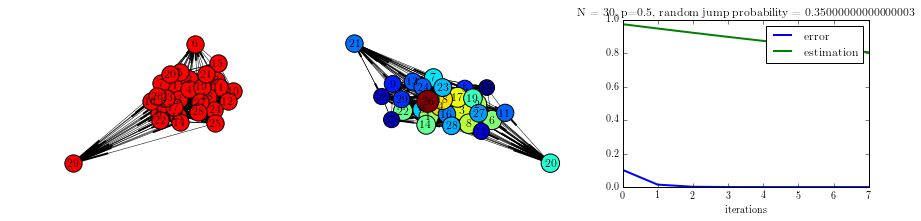

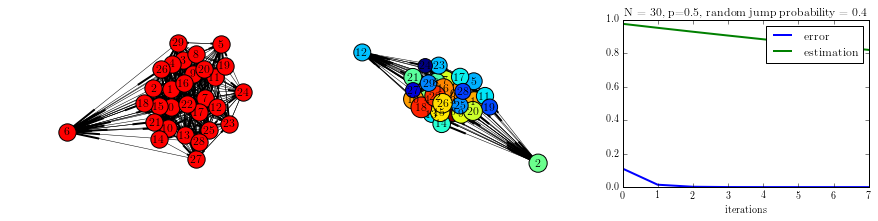

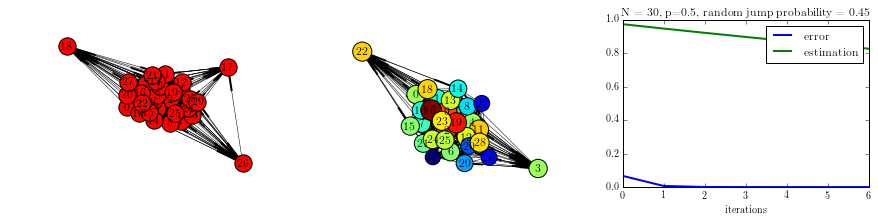

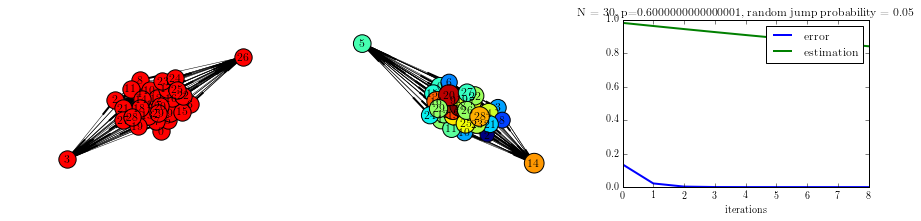

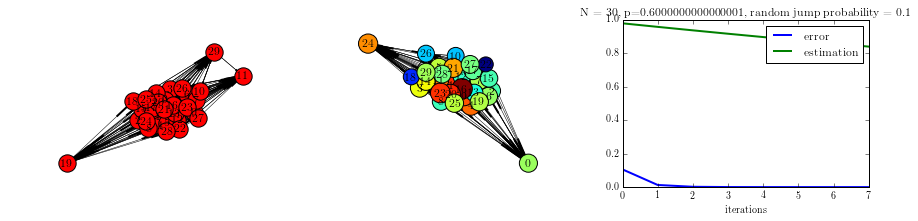

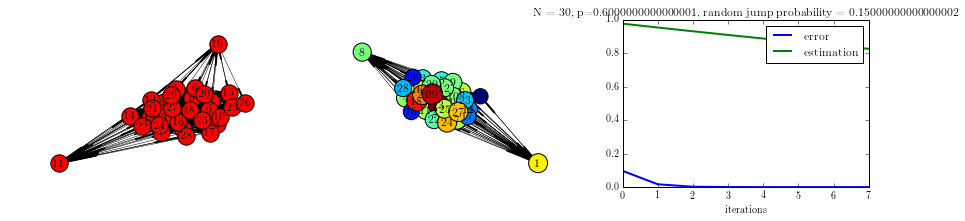

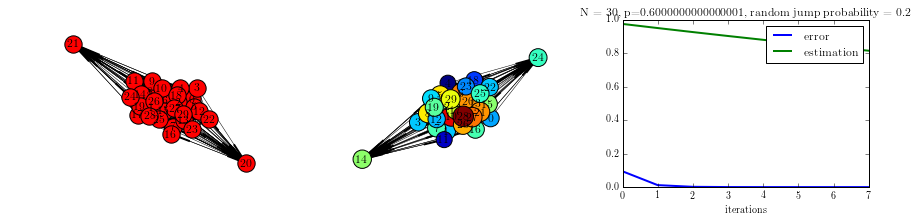

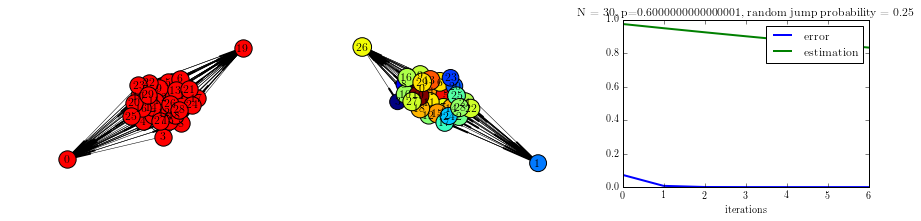

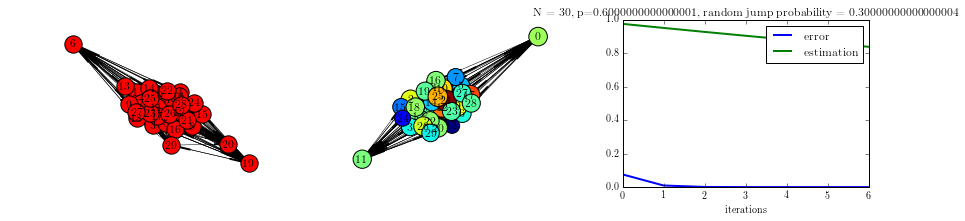

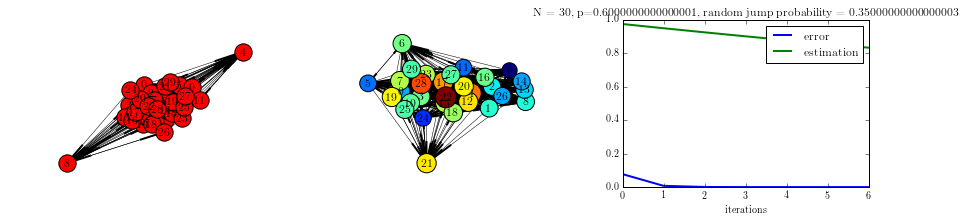

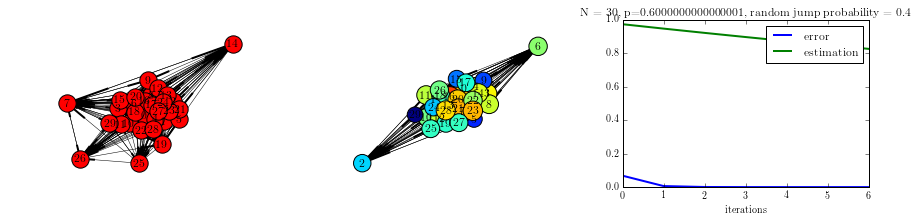

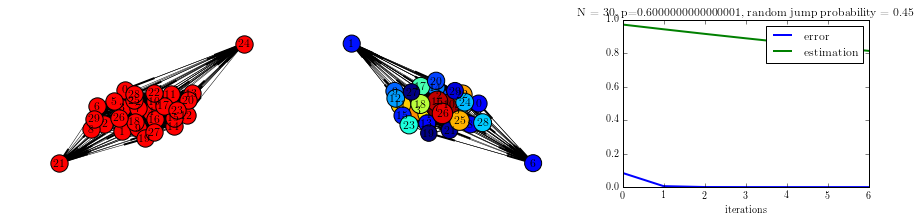

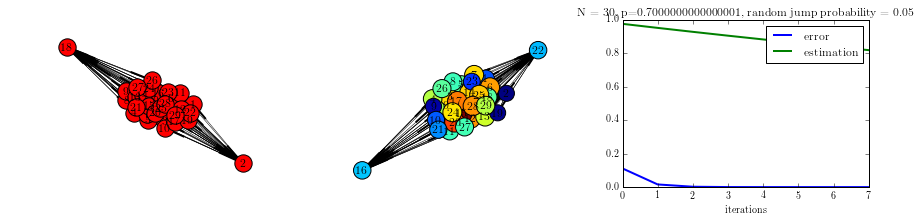

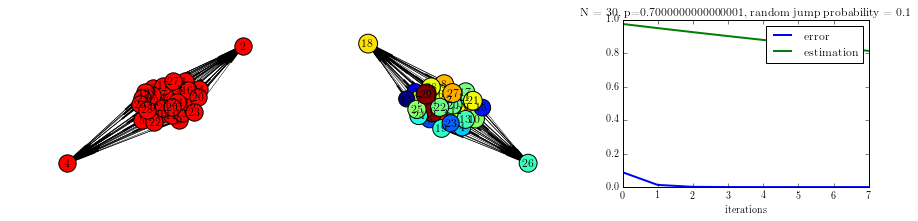

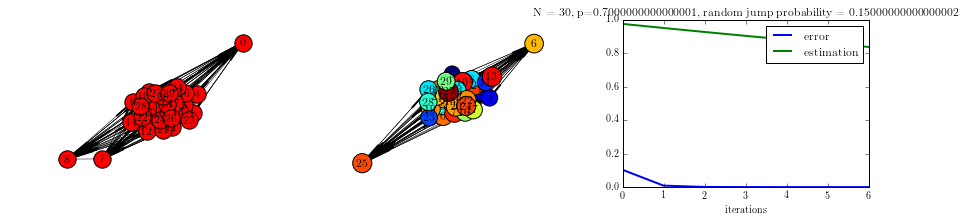

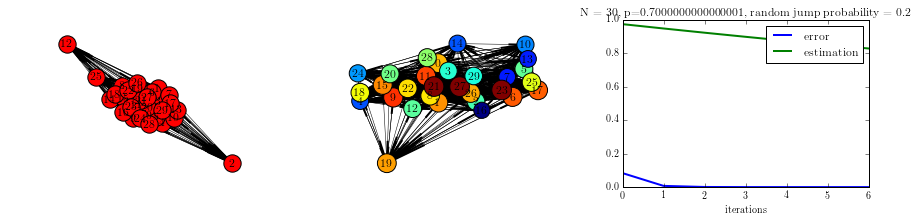

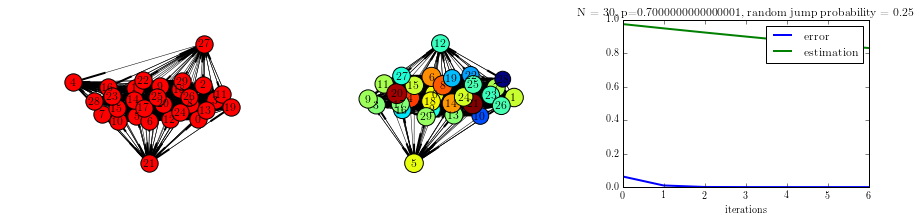

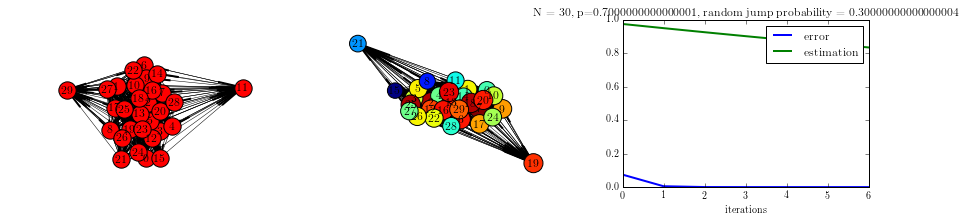

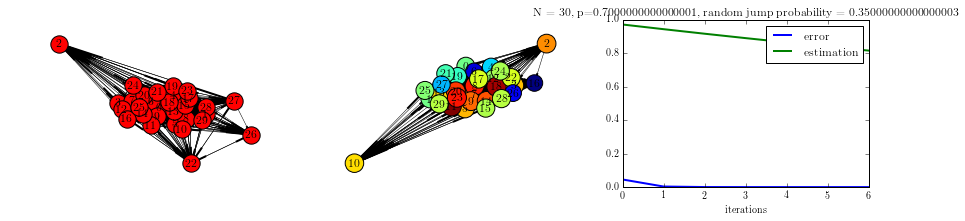

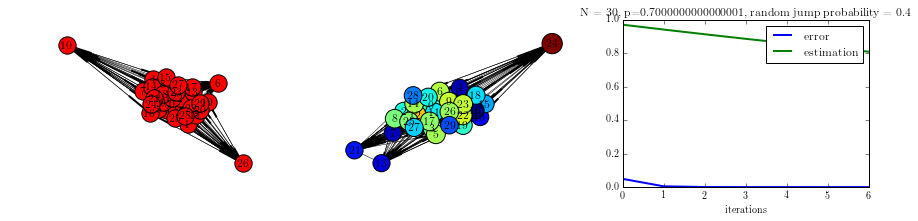

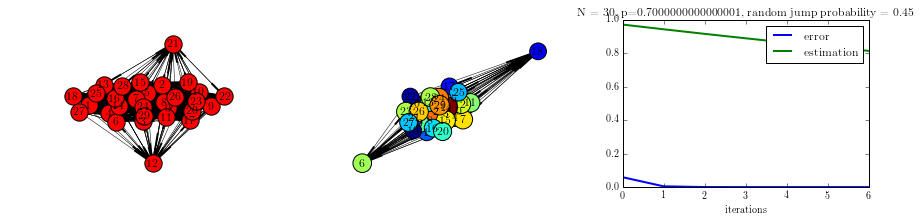

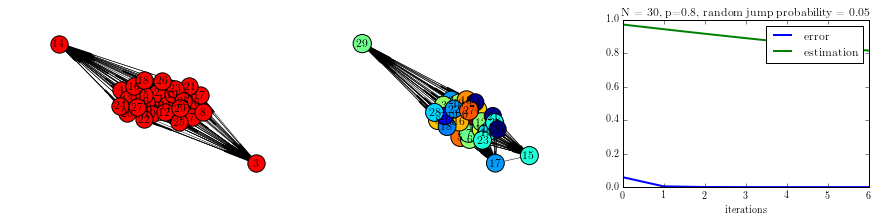

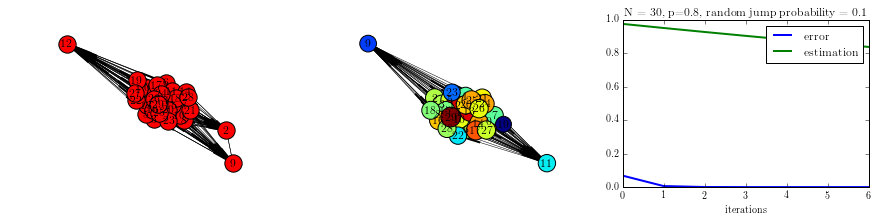

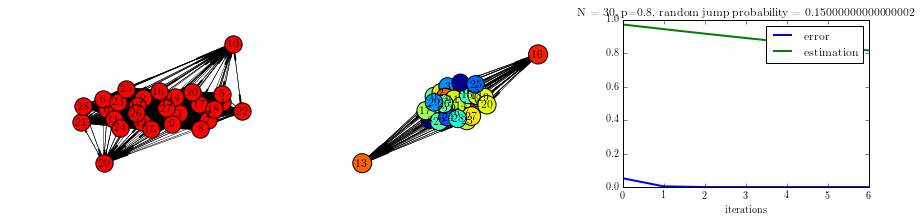

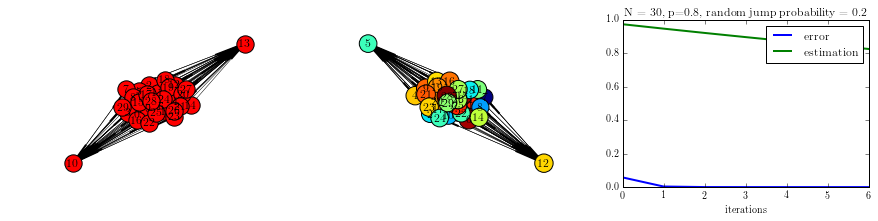

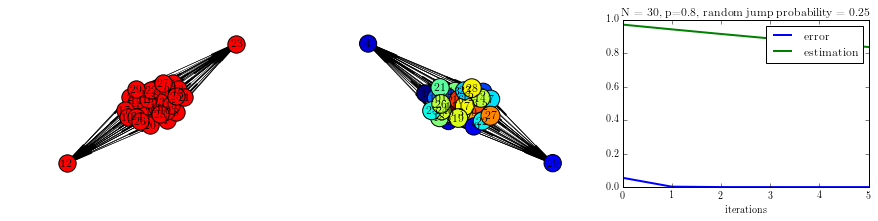

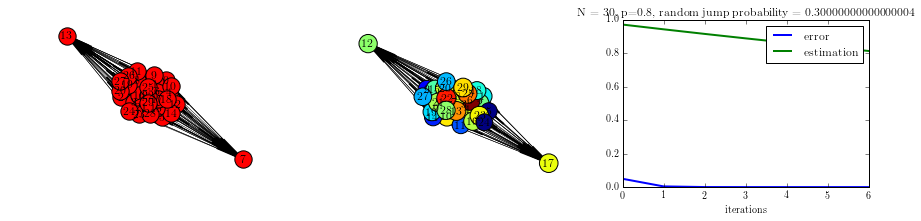

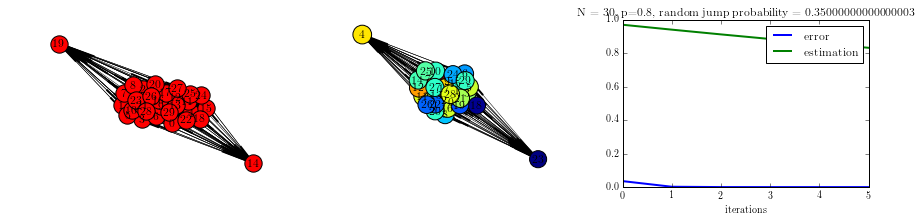

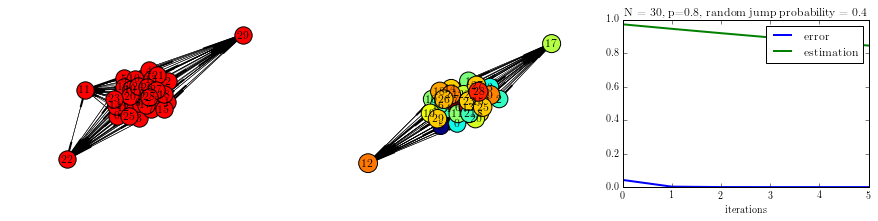

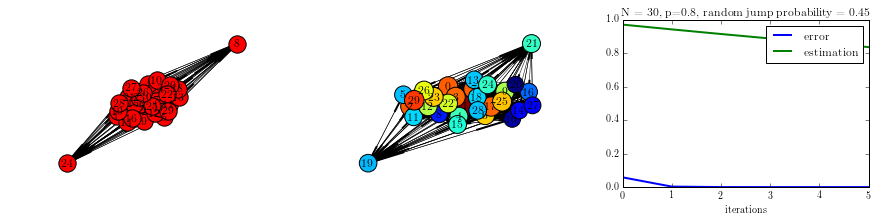

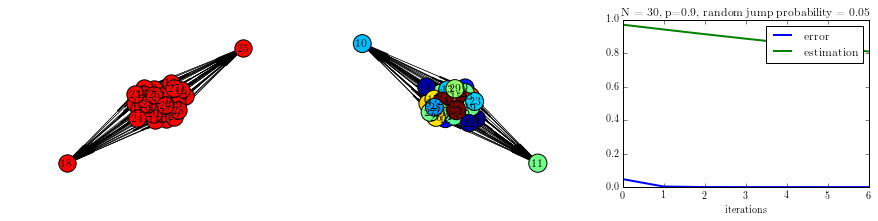

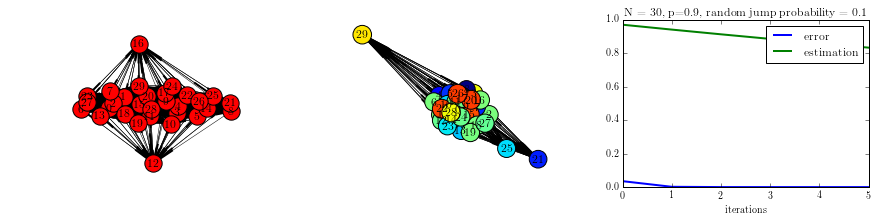

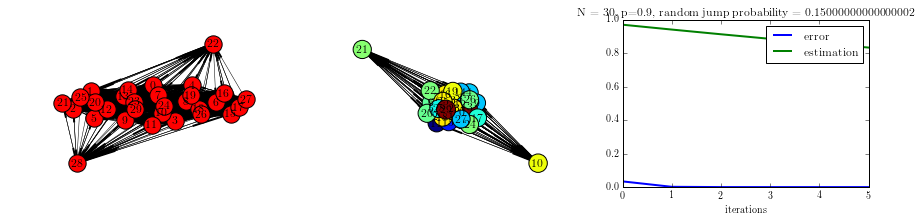

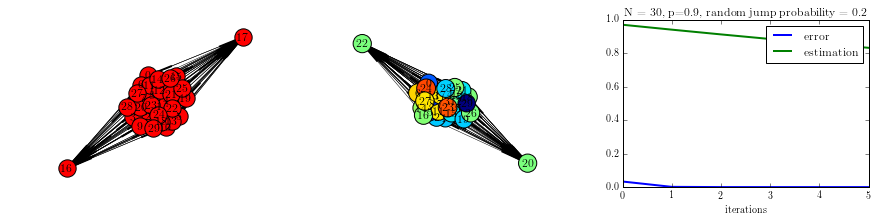

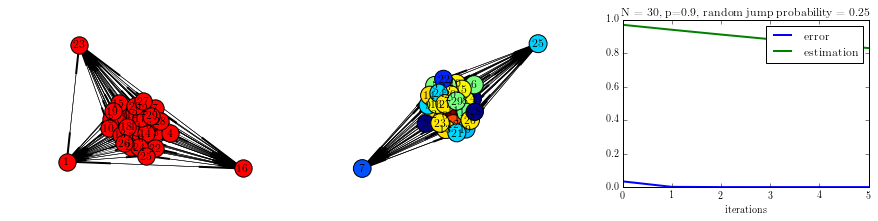

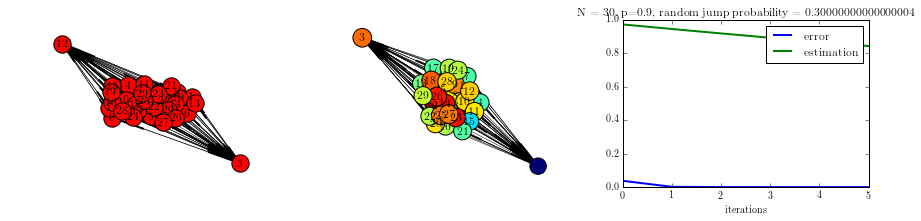

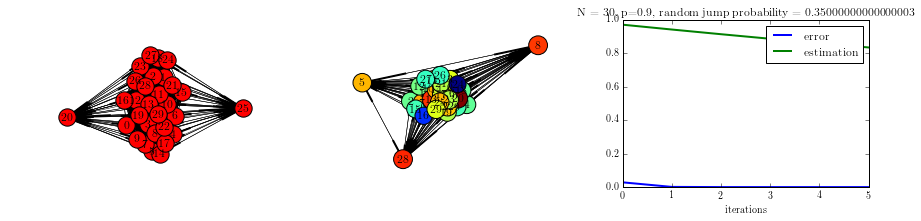

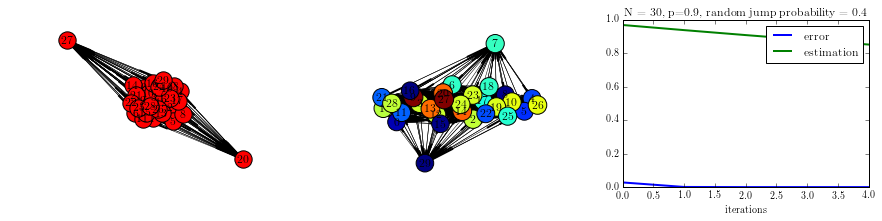

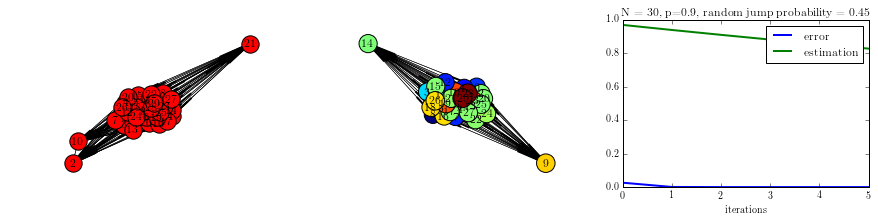

In [9]:
results2 = np.zeros((9, 9))
for i in range(1,10):
    p = 0.1 * i
    for j in range(1,10):
        proba = 0.05 * j
        results2[i-1,j-1] = test_page_rank(30, p, proba)

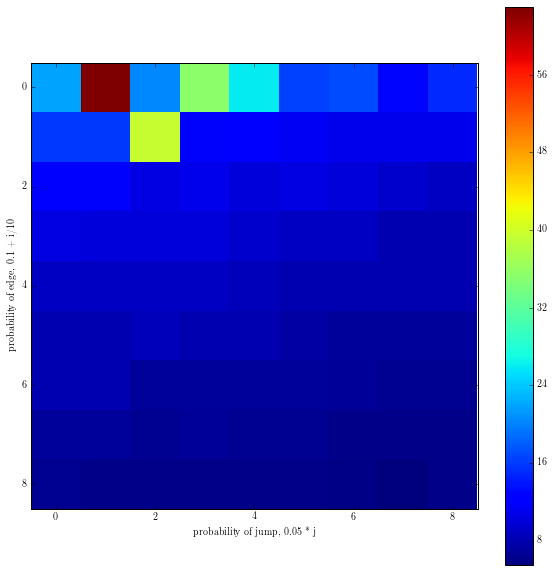

In [92]:
figure(figsize=(10,10))
imshow((results + results2)/2, interpolation='None')
ylabel('probability of edge, 0.1 + i/10')
xlabel('probability of jump, 0.05 * j')
colorbar()

После нескольких запусков при разных параметрах,получилось, что хуже всего сходится при маленьких вероятнстях ребра и вероятности перехода не по ссылке.

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [10]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [290]:
urls = ['http://ruchess.ru/']
site = get_site(urls[0])
links = []

N = 21
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

In [291]:
len(links), len(urls)

(869, 271)

Нарисуем граф ссылок сайта ruchess.ru и его же после обсчета page_rank.

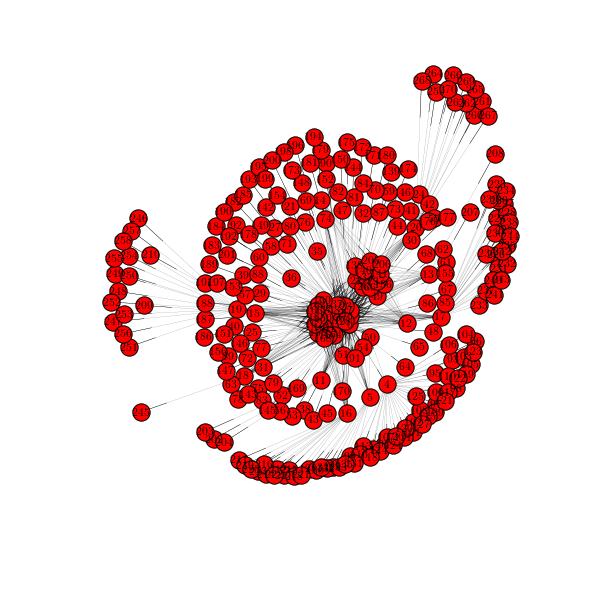

In [319]:
G = networkx.DiGraph()
G.add_edges_from(links)
figure(figsize=(10,10))
networkx.draw_networkx(G, width=0.1)
axis('off')
show()

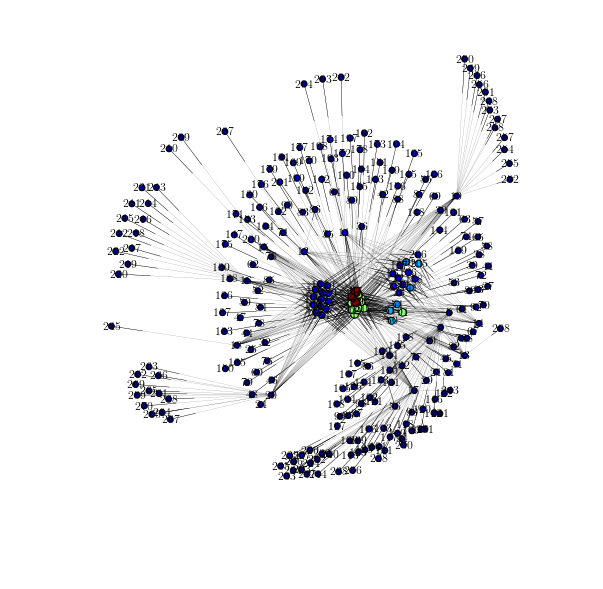

In [320]:
N = len(urls)
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(links, start_distribution, N=N, tolerance=10 ** (-9))

size_const = 10 ** 4
fig = figure(figsize=(10,10))
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)
axis('off')
show()

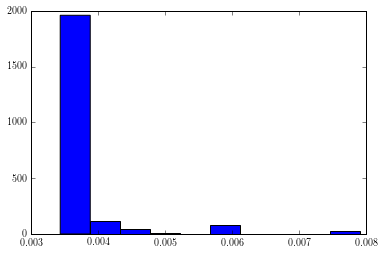

In [321]:
hist(pr_distribution, normed=True)
show()

Видим, что есть группа url, которые ссылаются друг на друга, также много url, которые не ссылаются ни на одну их просмотренных страниц. Отберем 20 топовых вершин по page_rank и нарисуем индуцированный на них подграф.

In [330]:
top_20 = sorted(pr_distribution)[-20:]
top_urls_indecies = list(filter(lambda i: pr_distribution[i] in top_20, range(len(pr_distribution))))
top_urls_edges = list(filter(lambda x: x[0] in top_urls_indecies and x[1] in top_urls_indecies, links))

In [351]:
top_20_urls = list()
for i in top_urls_indecies:
    top_20_urls.append(urls[i])

In [332]:
recount_edges = [(top_urls.index(x[0]), top_urls.index(x[1])) for x in top_urls_edges]

In [333]:
top_20 = np.array(top_20)

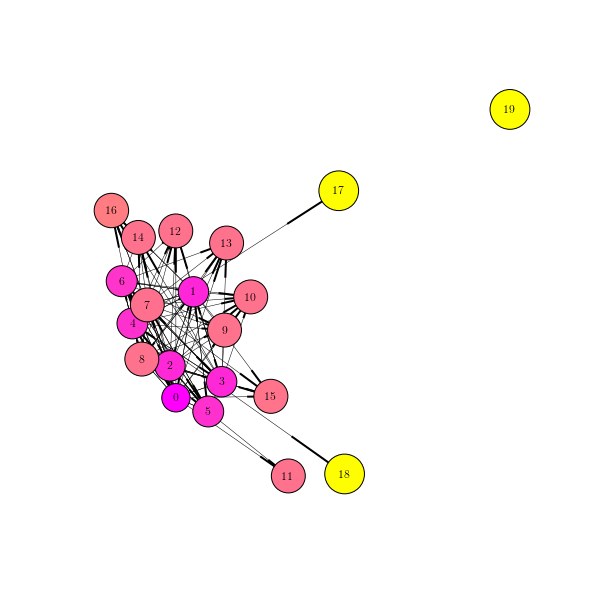

In [335]:
G = networkx.DiGraph(data=recount_edges)
G.add_nodes_from([(i, {'label': name}) for i, name in enumerate(top_20_urls)])

size_const = 2 * 10 ** 5
fig = figure(figsize=(10,10))
networkx.draw_networkx(G, width=0.5, node_size=size_const * top_20,
                       node_color=top_20, cmap='spring')
axis('off')
show()

Выведем page rank вершин из этой агломерации и их url

In [352]:
import pandas as pd
data = pd.DataFrame(columns = ['url', 'page_rank'])
data.url = top_20_urls
data.page_rank = top_20
data.sort_values('page_rank', ascending=False)

url  page_rank
19                                  http://ruchess.ru   0.007917
18  http://ruchess.ru/news/all/denis_khismatullin_...   0.007877
17  http://ruchess.ru/news/all/v_chekhii_nachalsya...   0.007877
16    http://ruchess.ru/persons_of_day/trifunovic_pd/   0.005925
15                  http://ruchess.ru/persons_of_day/   0.005796
14                      http://ruchess.ru/pos_of_day/   0.005759
11  http://ruchess.ru/championship/detail/2016/mat...   0.005756
13             http://ruchess.ru/live/test_broadcast/   0.005756
12  http://ruchess.ru/news/report/vip_zona_ot_mere...   0.005756
10  http://ruchess.ru/news/statements/gandikap_tur...   0.005756
9   http://ruchess.ru/news/inform/proekt_kalendary...   0.005756
8                   http://ruchess.ru/federation/smi/   0.005756
7                 http://ruchess.ru/chess_in_museums/   0.005727
6                       http://ruchess.ru/federation/   0.004813
5                     http://ruchess.ru/championship/   0.004769
4                             http://ruchess.ru/news/   0.004764
3                           http://ruchess.ru/search/   0.004641
2                http://ruchess.ru/personal/register/   0.004641
1                    http://ruchess.ru/personal/auth/   0.004601
0                                  http://ruchess.ru/   0.004018

Самый большой page rank у стартовой страницы, что в принципе ожидаемо - на нее можно перейти почти из всех страниц, далее идут новости- эти страницы также недалеко от главной и сами не ссылаются на важные страницы. Интересно, что когда я захожу на этот сайт, я тоже кликаю в основном по последним новостям, поэтому на месте разработчиков сразу бы их показывала на главной странице (а не во вкладке новостей).

Выведем как меняются веса при обычном распределении.

In [328]:
pr_distribution, traces = page_rank(links, start_distribution, N=N, tolerance=10 ** (-9), return_trace=True)

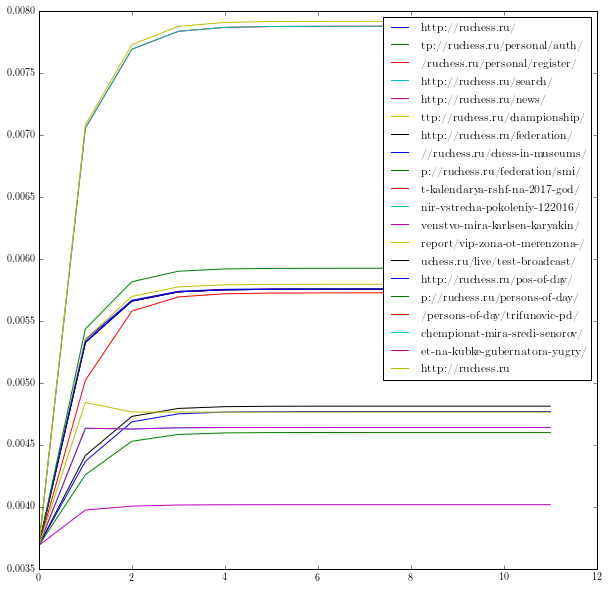

In [358]:
N = len(urls)
start_distribution = np.ones((1, N)) / N
pr_distribution, traces = page_rank(links, start_distribution, N=N, tolerance=10 ** (-9), return_trace=True)

figure(figsize=(10,10))
for i in top_urls_indecies:
    plot(traces[:, i], label=urls[i][-30:].replace('_', '-'))
legend()
show()

Если пользователь зашел на главную страницу.

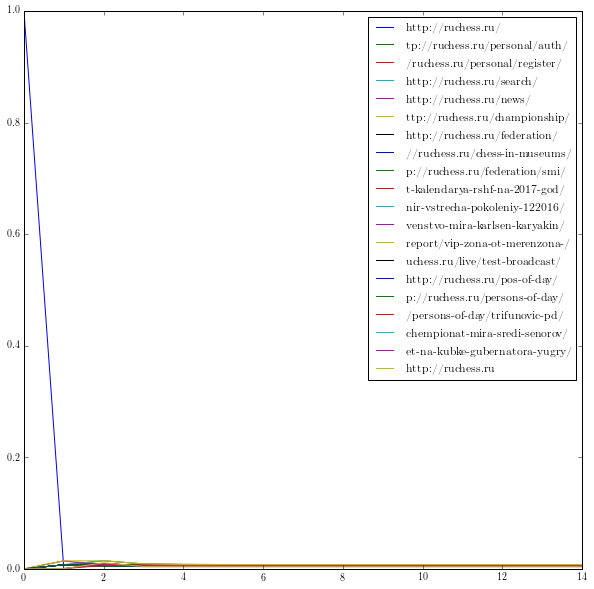

In [363]:
N = len(urls)
start_distribution = np.zeros((1, N))
start_distribution[0,0] = 1.
pr_distribution, traces = page_rank(links, start_distribution, N=N, tolerance=10 ** (-9), return_trace=True)

figure(figsize=(10,10))
for i in top_urls_indecies:
    plot(traces[:, i], label=urls[i][-30:].replace('_', '-'))
legend()
show()

То почти наверное он на ней не останется. Если пользователь зашел на одну из топовый по page_rank страниц.

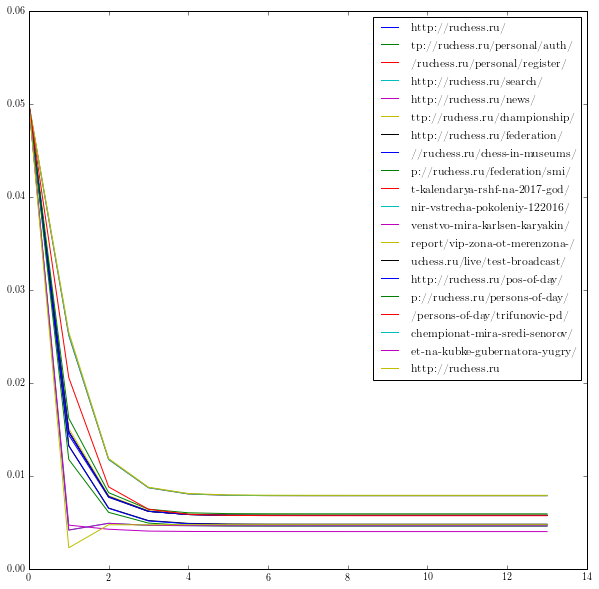

In [365]:
N = len(urls)
start_distribution = np.zeros((1, N))
start_distribution[0,top_urls_indecies] = 1. / 20
pr_distribution, traces = page_rank(links, start_distribution, N=N, tolerance=10 ** (-9), return_trace=True)

figure(figsize=(10,10))
for i in top_urls_indecies:
    plot(traces[:, i], label=urls[i][-30:].replace('_', '-'))
legend()
show()

То тоже скорее всего уйдет с них.

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [9]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.rstrip().split(' ')
            
            # print(split_line)
            # релевантность и id запроса

            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')


def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

In [7]:
relevs, qids, features = read_file('./imat2009-datasets/imat2009_learning.txt', 250)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
split_to_train_valid_test(relevs, qids, features,
                          './data/train.txt', './data/test.txt', 0.1, 0.1, 
                          valid_path='./data/valid.txt', valid_size=0.1)

LAMBDA MART

In [10]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/LambdaMART_300.txt > ./model/log_LambdaMART_300.txt

CPU times: user 540 ms, sys: 56 ms, total: 596 ms
Wall time: 28.6 s


MART

In [11]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 0 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/MART_300.txt > ./model/log_MART_300.txt

CPU times: user 408 ms, sys: 44 ms, total: 452 ms
Wall time: 22.4 s


In [12]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines])))
        if len(block_values) !=0:
            values.append(block_values)

        text = text[index:]
        
    return values

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

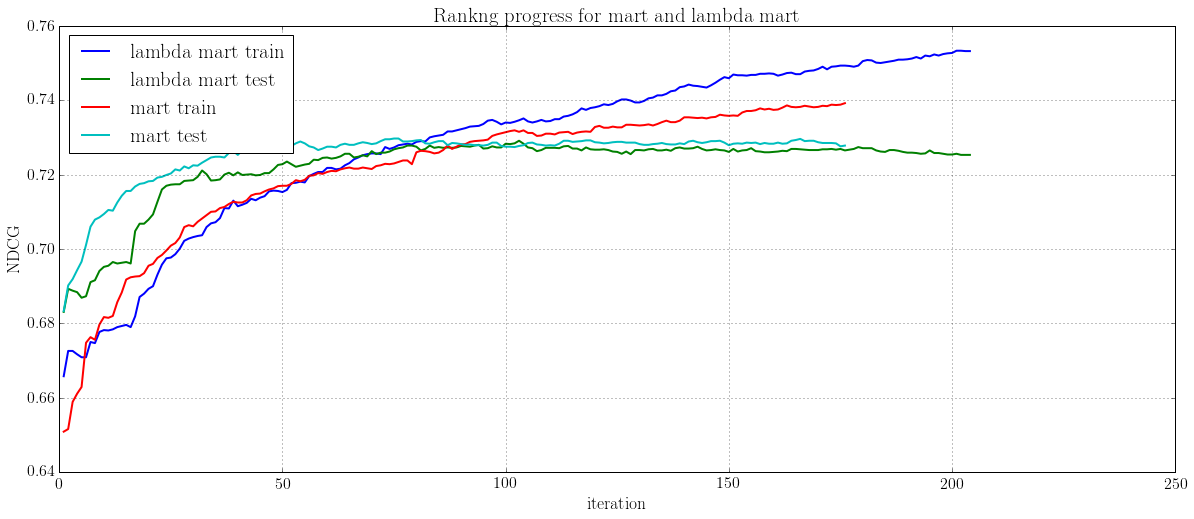

In [13]:
lambda_mart = read_metric_dependence_from_file('./model/log_LambdaMART_300.txt', 300)[0]
mart = read_metric_dependence_from_file('./model/log_MART_300.txt', 300)[0]

plt.figure(figsize=(20, 8))
plt.plot([lm[0] for lm in lambda_mart if lm != []],
         [lm[1] for lm in lambda_mart if lm != []],
         lw=2, label='lambda mart train')

plt.plot([lm[0] for lm in lambda_mart if lm != []],
         [lm[2] for lm in lambda_mart if lm != []],
         lw=2, label='lambda mart test')

plt.plot([m[0] for m in mart if m != []],
         [m[1] for m in mart if m != []],
         lw=2, label='mart train')

plt.plot([m[0] for m in mart if m != []],
         [m[2] for m in mart if m != []],
         lw=2, label='mart test')


plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('Rankng progress for mart and lambda mart')
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

<Ответ> Нет, нельзя сказать. Обе модели немного переобучились.

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

In [127]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 8 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/forrest.txt > ./model/log_forrest.txt

CPU times: user 2min 28s, sys: 12.9 s, total: 2min 41s
Wall time: 2h 8min 39s


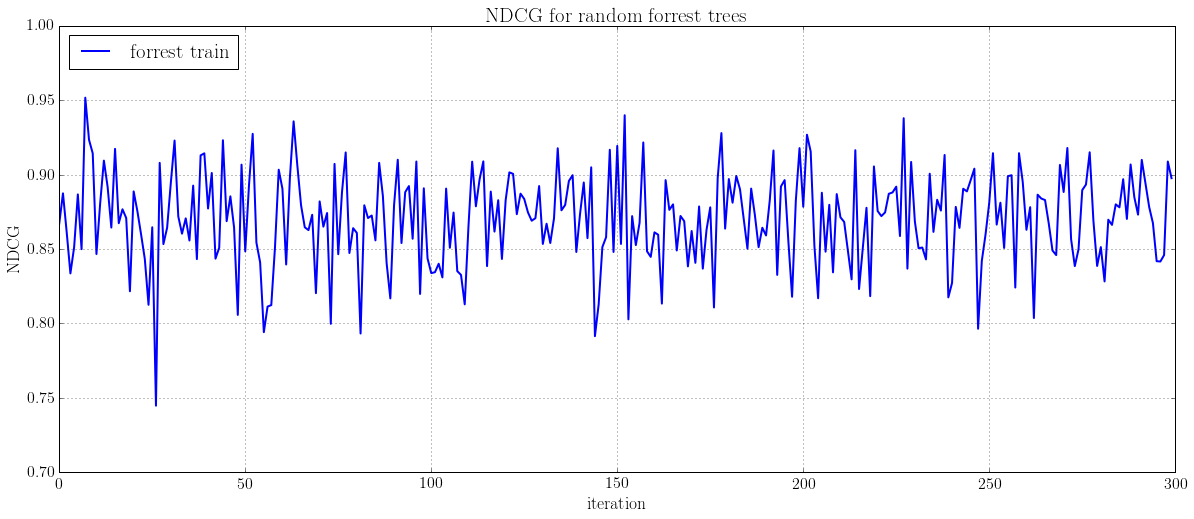

In [179]:
forrest = read_metric_dependence_from_file('./model/log_forrest.txt', 300)[0]
y = [lm[0] for lm in forrest if len(lm) > 0]

plt.figure(figsize=(20, 8))
plt.plot(range(len(y)), y,
         lw=2, label='forrest train')

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('NDCG for random forrest trees')
plt.legend(loc=2)
plt.grid()
plt.show()

In [ ]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -metric2t NDCG@10 -save ./model/net.txt > ./model/log_net.txt

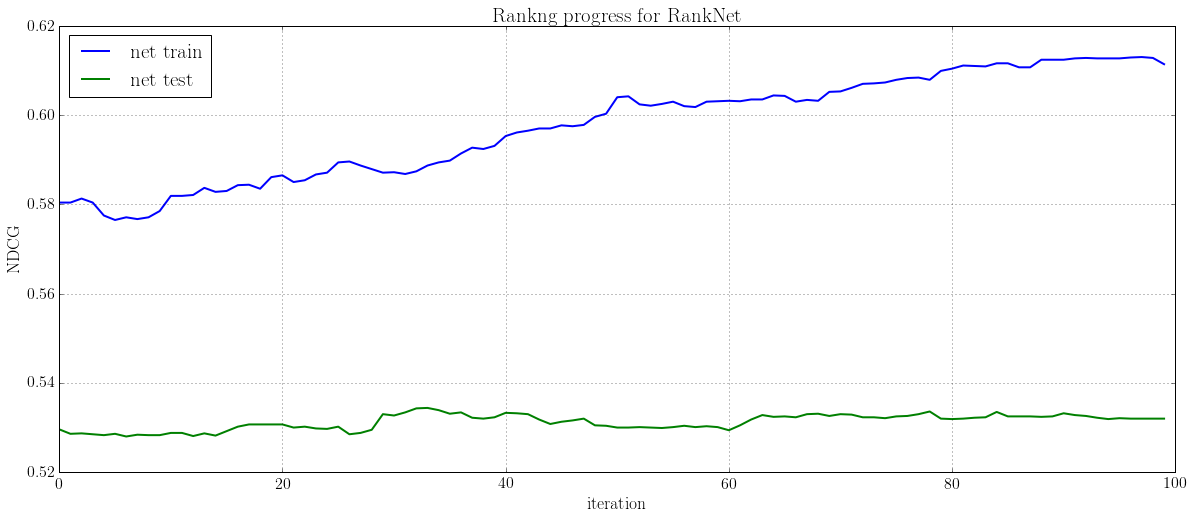

In [174]:
net = read_metric_dependence_from_file('./model/log_net.txt', 300)[0]

plt.figure(figsize=(20, 8))
plt.plot([lm[2] for lm in net if lm != []],
         lw=2, label='net train')

plt.plot([lm[3] for lm in net if lm != []],
         lw=2, label='net test')


plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('Rankng progress for RankNet')
plt.legend(loc=2)
plt.grid()
plt.show()

Сетка не зажгла

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ> Один и тот же запрос может чаще быть в трейне, чем на тесте и наоборот. Честно - перебрать все возможные разбиения запросов.

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

In [39]:
relevs, qids, features = read_file('./data/train.txt', 251)
split_to_train_valid_test(relevs, qids, features, './data/train.txt', './data/test.txt', 0.5, 0.5)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [85]:
def evaluate_model():
    with open('./model/LambdaMART_current.txt') as f:
        model = f.readlines()

    errors_test = list()
    for i in range(1, 300):
        next_last_tree = '\t<tree id="{}" weight="0.1">\n'.format(i+1)
        next_last_tree_index = model.index(next_last_tree)
        
        with open('./model/model_current.txt', 'w') as f:
            f.write(''.join(model[:next_last_tree_index]))
            f.write(model[-1])
        
        ! java -jar RankLib-2.1-patched.jar -load ./model/model_current.txt -test ./data/test.txt -metric2T NDCG@10 > ./model/log_test_evaluation.txt
        
        with open('./model/log_test_evaluation.txt') as f:
            test= f.readlines()
        
        errors_test.append(float(test[-1].split(': ')[1]))
    
    ! java -jar RankLib-2.1-patched.jar -load ./model/LambdaMART_current.txt -test ./data/test.txt -metric2T NDCG@10 > ./model/log_test_evaluation.txt
    
    with open('./model/log_test_evaluation.txt') as f:
        test= f.readlines()
        
    errors_test.append(float(test[-1].split(': ')[1]))
    
    return errors_test

In [86]:
errors_train = list()
errors_test = list()

for i in range(10):

    ! java -cp RankLib-2.1-patched.jar ciir.umass.edu.features.FeatureManager -input ./data/train.txt -output data/ -shuffle - silence
    relevs, qids, features = read_file('./data/train.txt.shuffled', 252)
    split_to_train_valid_test(relevs, qids, features, './data/train1.txt', './data/train2.txt', 0.5, 0.5)
    
    # model_name = './model/LambdaMART_{}.txt'.format(i)
    # model_log = './model/log_LambdaMART_{}.txt'.format(i)

    ! java -jar RankLib-2.1-patched.jar -train ./data/train1.txt -test ./data/test.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./model/LambdaMART_current.txt > ./model/log_LambdaMART_current.txt
    
    errors_train.append(read_metric_dependence_from_file('./model/log_LambdaMART_current.txt', 300)[0])
    errors_test.append(evaluate_model())

Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(487 ranked lists, 4924 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train

In [89]:
train_array = np.array([[er_it[1] for er_it in er if er_it != []] 
                        for er in errors_train])
train_mean = train_array.mean(axis=0)
train_sigma = train_array.std(axis=0)

test_array = np.array(errors_test)
test_mean = test_array.mean(axis=0)
test_sigma = test_array.std(axis=0)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


Populating the interactive namespace from numpy and matplotlib


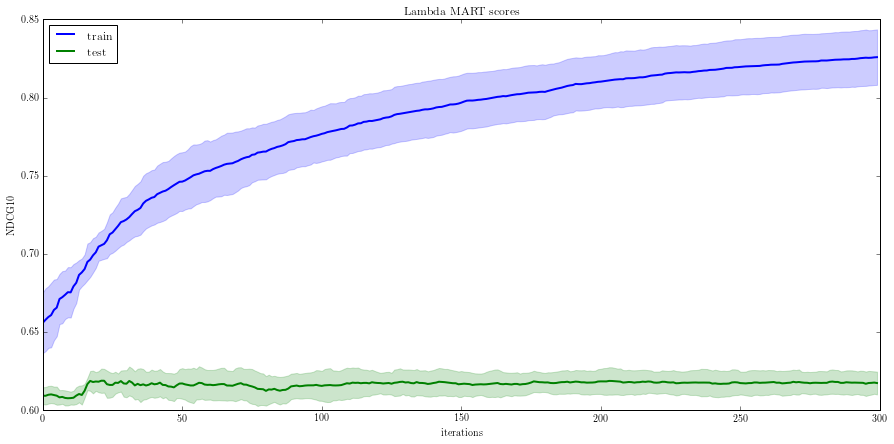

In [94]:
%pylab inline

figure(figsize(15,7))
plot(train_mean, label='train', lw=2, color='blue')
plot(test_mean, label='test', lw=2, color='green')
fill_between(range(300), train_mean - train_sigma, train_mean + train_sigma,
             alpha=0.2, color='blue')
fill_between(range(300), test_mean - test_sigma, test_mean + test_sigma, 
             alpha=0.2, color='green')
legend(loc=2)
title('Lambda MART scores')
ylabel('NDCG10')
xlabel('iterations')
show()

Сглаженная NDCG10 ведет себя более гладко (кто бы мог подумать), особенно на трейне.

Выполнять консольные команды можно в цикле:

In [ ]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

Если код выше не работает, воспользуйтесь следующей функцией.

In [ ]:
import subprocess

def _run_cmd(cmd, print=False):
    """ Запуск консольной команды cmd """
    
    PIPE = subprocess.PIPE
    p = subprocess.Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE,
                         stderr=subprocess.STDOUT, close_fds=True)
    output = ''
    
    while True:
        s = p.stdout.readline().decode('utf-8')
        if not s: break
        output += str(s)
        if print:
            print(s)
    
    return output